In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display

In [14]:
power = 1.2
griffin_lim_iters = 20

def _stft(y):
    n_fft, hop_length, win_length = 2048, 512, 2048
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

def _istft(y):
    n_fft, hop_length, win_length = 2048, 512, 2048
    return librosa.istft(y, hop_length=hop_length, win_length=win_length)

def _griffin_lim(S):
    '''librosa implementation of Griffin-Lim
    Based on https://github.com/librosa/librosa/issues/434
    '''
    angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
    S_complex = np.abs(S).astype(np.complex)
    y = _istft(S_complex * angles)
    for i in range(griffin_lim_iters):
        angles = np.exp(1j * np.angle(_stft(y)))
        y = _istft(S_complex * angles)
    return y

def inv_spectrogram(spectrogram):
    pad = np.zeros(shape=[1, spectrogram.shape[1]])
    spectrogram = np.concatenate([pad, spectrogram], axis=0)
    return _griffin_lim(spectrogram ** power)          # Reconstruct phase

In [3]:
from os import listdir
from os.path import isfile, join
import ntpath

data_dir = '/home/scpark/hard/datasets/musdb18_raw_spec'
data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.npz' in f]

print(len(data_files))

2021


In [4]:
def get_data(batch, length):

    read_length = 0
    audios = []
    vocals = []
    
    while(read_length < batch * length):
        file_index = np.random.randint(0, len(data_files), 1)[0]
        data = np.load(data_files[file_index])
        
        audio = data['audio']
        vocal = data['vocal']
        
        need_length = batch * length - read_length
        
        if audio.shape[0] > need_length:
            audio = audio[:need_length]
            vocal = vocal[:need_length]
            
        read_length += audio.shape[0]
        audios.append(audio)
        vocals.append(vocal)
        
    audios = np.concatenate(audios, axis=0)
    audios = np.reshape(audios, [batch, length, audios.shape[1], 2])
    
    vocals = np.concatenate(vocals, axis=0)
    vocals = np.reshape(vocals, [batch, length, vocals.shape[1], 2])
    
    return audios, vocals
    

(10, 200, 1025, 2) (10, 200, 1025, 2)


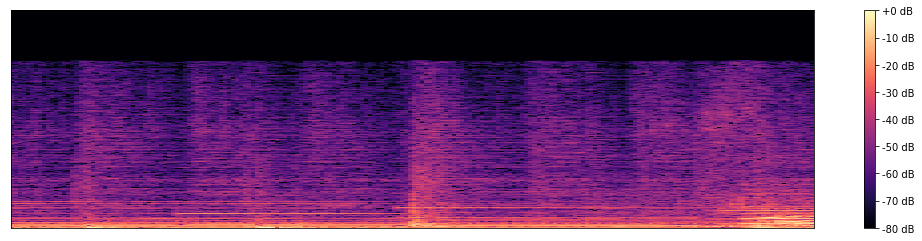

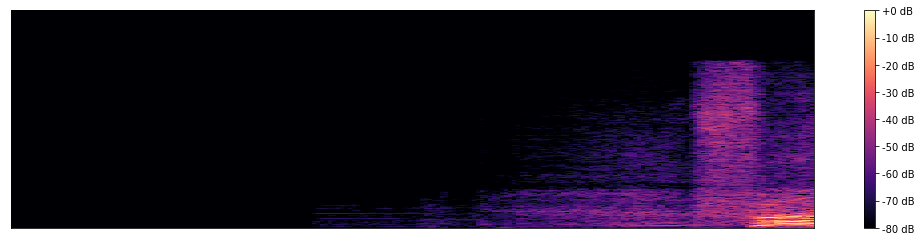

In [5]:
_audios, _vocals = get_data(10, 200)
print(_audios.shape, _vocals.shape)

plt.figure(figsize=[18, 4])
librosa.display.specshow(librosa.amplitude_to_db(np.abs(_audios[0, :, :, 0]), ref=np.max).T)
plt.colorbar(format='%+2.0f dB')
plt.show()

plt.figure(figsize=[18, 4])
librosa.display.specshow(librosa.amplitude_to_db(np.abs(_vocals[0, :, :, 0]), ref=np.max).T)
plt.colorbar(format='%+2.0f dB')
plt.show()


In [6]:
def conv(x, filters):
    
    # conv
    y = tf.layers.conv2d(x, filters=filters, kernel_size=[3, 3], padding='same')
    # batch norm
    #y = tf.layers.batch_normalization(y)
    # relu
    y = tf.nn.relu(y)
    
    return y

def deconv(x, filters):
    # conv
    y = tf.layers.conv2d_transpose(x, filters=filters, kernel_size=[3, 3], padding='same')
    # batch norm
    #y = tf.layers.batch_normalization(y)
    # relu
    y = tf.nn.relu(y)
    
    return y
    
def pooling(x):
    # pooling
    y = tf.layers.max_pooling2d(x, pool_size=[2, 2], strides=[2, 2])
    return y

def upsampling(x, filters):
    # upsampling
    y = tf.layers.conv2d_transpose(x, filters=filters, kernel_size=[5, 5], strides=(2, 2), padding='same')
    y = tf.nn.relu(y)
    
    return y

def spec_unet(x):
    channels = [32, 64, 128, 256, 512]
    d1 = conv(x, channels[0])
    d1 = conv(d1, channels[0])
    print('d1 : ', d1)
    
    d2 = pooling(d1)
    d2 = conv(d2, channels[1])
    d2 = conv(d2, channels[1])
    print('d2 : ', d2)
    
    d3 = pooling(d2)
    d3 = conv(d3, channels[2])
    d3 = conv(d3, channels[2])
    print('d3 : ', d3)
    
    d4 = pooling(d3)
    d4 = conv(d4, channels[3])
    d4 = conv(d4, channels[3])
    print('d4 : ', d4)
    
    d5 = pooling(d4)
    d5 = conv(d5, channels[4])
    d5 = conv(d5, channels[4])
    print('d5 : ', d5)

    u4 = upsampling(d5, channels[3])
    u4 = tf.concat([u4, d4], axis=-1)
    u4 = deconv(u4, channels[3])
    u4 = deconv(u4, channels[3])
    print('u4 : ', u4)
    
    u3 = upsampling(u4, channels[2])
    u3 = tf.concat([u3, d3], axis=-1)
    u3 = deconv(u3, channels[2])
    u3 = deconv(u3, channels[2])
    print('u3 : ', u3)
    
    u2 = upsampling(u3, channels[1])
    u2 = tf.concat([u2, d2], axis=-1)
    u2 = deconv(u2, channels[1])
    u2 = deconv(u2, channels[1])
    print('u2 : ', u2)
    
    u1 = upsampling(u2, channels[0])
    u1 = tf.concat([u1, d1], axis=-1)
    u1 = deconv(u1, channels[0])
    u1 = deconv(u1, channels[0])
    print('u1 : ', u1)
    
    y = tf.layers.conv2d(u1, filters=2, kernel_size=[1, 1], padding='same')
    return y
    

In [7]:
Batch = None
Length = None
Freq = 1024
Channel = 2

tf.reset_default_graph()

audios = tf.placeholder(dtype=tf.float32, shape=[Batch, Length, Freq, Channel])
vocals = tf.placeholder(dtype=tf.float32, shape=[Batch, Length, Freq, Channel])

outputs = spec_unet(audios)

loss = tf.losses.mean_squared_error(labels=vocals, predictions=outputs)
global_step = tf.Variable(0, name='global_step')
train_step = tf.train.RMSPropOptimizer(1e-3).minimize(loss, global_step)

'''
Session Open
'''

sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
#saver.restore(sess, "save/mdensenet-5000")
print("Model restored.")

# tensorboard writer
loss_hist = tf.summary.scalar('loss', loss)
writer = tf.summary.FileWriter('save/specunet', sess.graph)

print('graph create')

d1 :  Tensor("Relu_1:0", shape=(?, ?, 1024, 32), dtype=float32)
d2 :  Tensor("Relu_3:0", shape=(?, ?, 512, 64), dtype=float32)
d3 :  Tensor("Relu_5:0", shape=(?, ?, 256, 128), dtype=float32)
d4 :  Tensor("Relu_7:0", shape=(?, ?, 128, 256), dtype=float32)
d5 :  Tensor("Relu_9:0", shape=(?, ?, 64, 512), dtype=float32)
u4 :  Tensor("Relu_12:0", shape=(?, ?, 128, 256), dtype=float32)
u3 :  Tensor("Relu_15:0", shape=(?, ?, 256, 128), dtype=float32)
u2 :  Tensor("Relu_18:0", shape=(?, ?, 512, 64), dtype=float32)
u1 :  Tensor("Relu_21:0", shape=(?, ?, 1024, 32), dtype=float32)
Model restored.
graph create


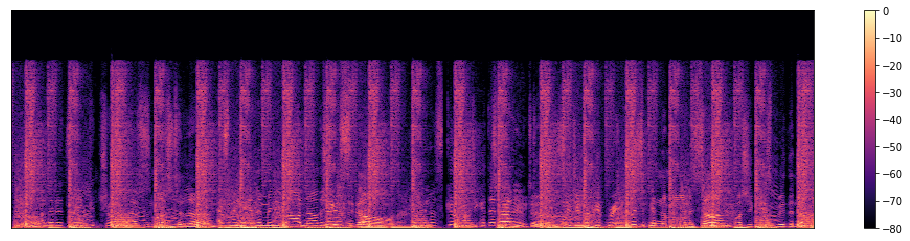

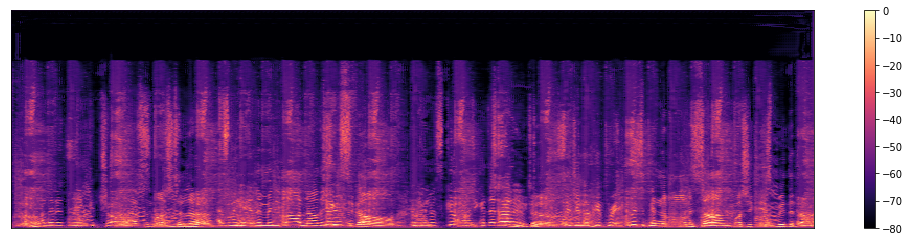

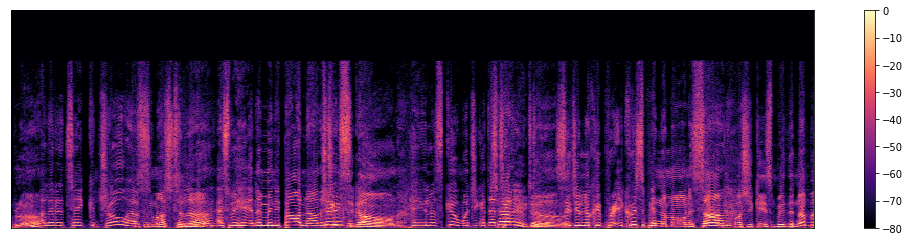

13103 0.4026415
13104 0.7363847
13105 3.6539872
13106 0.0036215894
13107 0.5369553
13108 0.03629649
13109 0.52338415
13110 0.5673609
13111 1.0861824
13112 0.7551543
13113 0.020155916
13114 0.005646957
13115 0.36607313
13116 0.77807456
13117 1.3356646
13118 0.21106274


KeyboardInterrupt: 

In [20]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

# training parameters

loops = 100
batch = 1
length = 768
_learninig_rate = 1e-3

while(True):
    for _ in tqdm(range(loops)):
        _audios, _vocals = get_data(batch, length)
        _audios = np.abs(_audios)[:, :, :-1]
        _vocals = np.abs(_vocals)[:, :, :-1]
        
        fetches = [train_step, loss, outputs, global_step, loss_hist]
        _, _loss, _outputs, _global_step, _loss_hist = \
            sess.run(fetches, feed_dict={audios: _audios, vocals: _vocals})
        print(_global_step, _loss)
        
        if _global_step % 10 == 0:
            writer.add_summary(_loss_hist, _global_step)
        
        if _global_step % 1000 == 0:
            save_path = saver.save(sess, 'save/specunet', global_step=_global_step)
            print("Model saved in path: %s" % save_path)
        
    clear_output()
    #_outputs = np.clip(_outputs, 0., 1.)
    
    plt.figure(figsize=[18, 4])
    D = librosa.amplitude_to_db(np.abs(_audios[0, :, :, 0]), ref=np.max)
    librosa.display.specshow(D.T)
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=[18, 4])
    D = librosa.amplitude_to_db(np.abs(_outputs[0, :, :, 0]), ref=np.max)
    librosa.display.specshow(D.T)
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=[18, 4])
    D = librosa.amplitude_to_db(np.abs(_vocals[0, :, :, 0]), ref=np.max)
    librosa.display.specshow(D.T)
    plt.colorbar()
    plt.show()



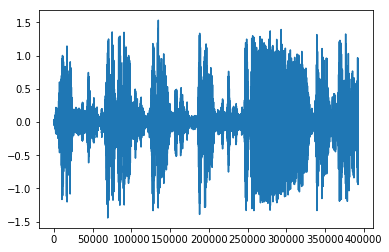

In [21]:
_outputs_wave = inv_spectrogram(np.abs(_audios[0, :, :, 0].T))

plt.plot(_outputs_wave)
plt.show()

import IPython.display as ipd
ipd.Audio(_outputs_wave, rate=44100)

In [ ]:
_outputs_wave = inv_spectrogram(np.abs(_outputs[0, :, :, 0].T))

plt.plot(_outputs_wave)
plt.show()

import IPython.display as ipd
ipd.Audio(_outputs_wave, rate=44100)

In [ ]:
print(_outputs.shape)